In [72]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

# !wget -O selected.zip https://www.dropbox.com/s/ow1delunc6sb5if/selected.zip?dl=1
# !unzip selected.zip
# !wget -O parrington.zip https://www.dropbox.com/s/aa59g3j160e0qec/parrington.zip?dl=1
# !unzip parrington.zip
!wget -O input_img.zip https://www.dropbox.com/s/yuwtdti59gucs0t/input_img.zip?dl=1
!unzip input_img.zip

--2022-04-28 14:24:24--  https://www.dropbox.com/s/yuwtdti59gucs0t/input_img.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/yuwtdti59gucs0t/input_img.zip [following]
--2022-04-28 14:24:24--  https://www.dropbox.com/s/dl/yuwtdti59gucs0t/input_img.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0b2efaba11f9e2da6ff71f7d6.dl.dropboxusercontent.com/cd/0/get/BkS7_0ZCdbxDC1MWutQfFAtjiSIhH0hQrU6d99yvq73292GWq0DIEwEnTCFJNun7JVoaTY93Zc6Yg8nWdcVzaOsDhnPHxfkad6Yxp2-N5CiprjlWDwUHLAW-BtO3Qm1dboE8XMDCTrkpP7eMdPxaG4bKbegqKHBY8ppohjwoChF9d1docjo4RNGnXsTTRfhJLY8/file?dl=1# [following]
--2022-04-28 14:24:25--  https://ucb0b2efaba11f9e2da6ff71f7d6.dl.dropboxusercontent.com/cd/0/get/BkS7_0ZCdbxDC1MWutQfFAtjiSIhH0hQrU6d99yvq7

In [91]:
import os
import numpy as np
import cv2 as cv
from scipy.spatial import KDTree
import random
from matplotlib import pyplot as plt
import glob
from PIL import Image
from tqdm import tqdm

In [92]:
def SIFT(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  sift = cv.xfeatures2d.SIFT_create()
  k, d = sift.detectAndCompute(gray, None)
  d = np.array(d)
  return k, d

In [93]:
def cylindrical_warp(src, f):
  map_x = np.zeros((src.shape[0], src.shape[1]), dtype=np.float32)
  map_y = np.zeros((src.shape[0], src.shape[1]), dtype=np.float32)
  c = [ src.shape[0] / 2.0, src.shape[1] / 2.0 ]
  f2 = f ** 2
  for i in range(src.shape[0]):
    for j in range(src.shape[1]):
      map_x[i][j] = f * np.tan( 1.0 * (j - c[1]) / f ) + c[1]
      map_y[i][j] = 1.0 * (i - c[0]) / f * np.sqrt( (map_x[i][j] - c[1])**2 + f2 ) + c[0]
  warp = cv.remap(src, map_x, map_y, cv.INTER_LINEAR,	borderMode = cv.BORDER_CONSTANT)
  cutoff = [0, src.shape[1] - 1]
  black = np.zeros(3)  # Black pixel.
  while np.array_equal(warp[ int(warp.shape[0]/2), cutoff[0] ], black):
    cutoff[0] += 1
  while np.array_equal(warp[ int(warp.shape[0]/2), cutoff[1] ], black):
    cutoff[1] -= 1
  warp = warp[ :, cutoff[0]+2 : cutoff[1]-1 ]
  
  return warp

In [94]:
def match_feat(kp_tar, des_tar, kp_src, des_src):
  print("matching feature")
  tree = [KDTree(des_tar), KDTree(des_src)]
  match = [[], []]
  
  for point in des_src:
    dist0, ind0 = tree[0].query(point, k=2)
    if dist0[0] / dist0[1] > 0.5:
      continue
    dist0, ind0 = dist0[0], ind0[0]
    dist1, ind1 = tree[1].query(des_tar[ind0], k=1)
    if des_src[ind1][0] == point[0] and des_src[ind1][1] == point[1]:
      match[0].append( kp_tar[ind0].pt )
      match[1].append( kp_src[ind1].pt )
  # print("matching feature #", len(match[1]))
  # for i in (0,1):
  #   cv.drawKeypoints(img[i], match[i], img[i])
  #   cv.imwrite('sift_keypoints'+ str(i) +'.jpg', img[i])
  return np.array(match[0]), np.array(match[1])

# p1, p2 = match_feat(kp[15:17], des[15:17])

In [95]:
def plot_matches(p1, p2, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type
    
    ax.plot(p1[:, 0], p1[:, 1], 'xr')
    ax.plot(p2[:, 0] + offset, p2[:, 1], 'xr')
     
    ax.plot([p1[:, 0], p2[:, 0] + offset], [p1[:, 1], p2[:, 1]],
            'r', linewidth=0.1)

    plt.show()

# total_img = np.concatenate((img[16], img[15]), axis=1)
# plot_matches(p2, p1, total_img)

In [96]:
def homography(p1, p2):
  rows = []
  for a, b in zip(p1, p2):
    row1 = [0, 0, 0, b[0], b[1], 1, -a[1]*b[0], -a[1]*b[1], -a[1]]
    row2 = [b[0], b[1], 1, 0, 0, 0, -a[0]*b[0], -a[0]*b[1], -a[0]]
    rows.append(row1)
    rows.append(row2)
  rows = np.array(rows)
  U, s, V = np.linalg.svd(rows)
  H = V[-1].reshape(3, 3)
  H = H/H[2, 2] # standardize to let w*H[2,2] = 1
  return H
def cylin_affine(p1, p2):
  A = np.zeros( (p1.shape[0] * 2, 6) )
  B = np.zeros( (p1.shape[0] * 2, 1) )
  ind = 0
  A_rows = []
  B_rows = []
  for a, b in zip(p1, p2):
    row1 = [1, 0, b[0], b[1], 0, 0]
    row2 = [0, 1, 0, 0, b[0], b[1]]
    A_rows.append(row1)
    A_rows.append(row2)
    B_rows.append( [a[0]] )
    B_rows.append( [a[1]] )
  A = np.array(A_rows)
  B = np.array(B_rows)
  cyl_aff , _, _, _ = np.linalg.lstsq(A, B, rcond=-1)
  cyl_aff = np.array( [[ cyl_aff[2], cyl_aff[3], cyl_aff[0] ], [ cyl_aff[4], cyl_aff[5], cyl_aff[1]]] ).squeeze()
  return cyl_aff

def ransac(tar, src, thresh = 0.5, k = 3, iter = 3000, method = "affine"):
  print("Ransac")
  max_match = 0
  all_match = []
  best_match_pairs = [[], []]
  best_trans = None
  for i in range(iter):
    match = 0
    match_pairs = [[],[]]
    sam = random.sample( range(src.shape[0]), k )

    if method == "homography":
      H = homography( tar[sam], src[sam] )
    elif method == "affine":
      A = cylin_affine( tar[sam], src[sam] )

    # # check rank 
    # if np.linalg.matrix_rank(H) < 3:
    #   continue
    for i in range(src.shape[0]):
      p = np.append(src[i], 1)
      if method == "homography":
        pred = np.dot(H, p)
        pred = np.array( [ pred[0]/pred[2], pred[1]/pred[2] ])
      elif method == "affine":
        pred = np.dot(A, p)
      # print(pred)
      if np.linalg.norm(pred - tar[i], ord = 2) < thresh:
        match += 1
        match_pairs[0].append(tar[i])
        match_pairs[1].append(src[i])
    all_match.append(match)
    if match > max_match:
      max_match = match
      best_match_pairs = match_pairs
      if method == "homography":
        best_trans = H.copy()
      elif method == "affine":
        best_trans = A.copy()
    
  print("Inliers / Total pairs:", max_match, "/", src.shape[0], "(", max_match/src.shape[0], ")")
  # print(sorted(all_match, reverse=True))
  return best_trans, np.array(best_match_pairs)

# A, pairs = ransac(p2, p1)

# total_img = np.concatenate((img[16], img[15]), axis=1)
# plot_matches(pairs[0], pairs[1], total_img)

In [116]:
def stitch_img(img1, img2, trans):
  print("Stitching image")
  # stitch img2 to img1
  # img1 = cv.normalize(img1.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
  # img2 = cv.normalize(img2.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
  corners = np.array([[0, 0, 1], [0, img2.shape[0], 1], [img2.shape[1], 0, 1], [img2.shape[1], img2.shape[0], 1]]).T
  # print(corners)

  # find corners of the warped image
  mapped_corners = np.dot(trans, corners).T.astype("int32")
  # mapped_corners = mapped_corners / mapped_corners[2, :]
  # mapped_corners = mapped_corners[:-1, :].T.astype("int32")
  # print(mapped_corners)

  # shift the warpped image downwards if the transformed y coordinate is a negative value
  min_v = min(0, min(mapped_corners[:, 1]))
  max_v = max(img1.shape[0], max(mapped_corners[:, 1]))
  max_h = max(img1.shape[1], max(mapped_corners[:, 0]))
  
  mapped_h = [ min(mapped_corners[:, 0]), max(mapped_corners[:, 0]) ]
  mapped_v = [ min(mapped_corners[:, 1]) - min_v, max(mapped_corners[:, 1]) - min_v ]

  trans_new = trans.copy()
  trans_new[1, 2] += abs(min_v)
  
  # shift the base image downwards if the transformed y coordinate is a negative value
  top_pad = np.zeros( ( abs(min_v), img1.shape[1], 3 ) )
  bot_pad = np.zeros( ( max_v - img1.shape[0], img1.shape[1], 3 ) )
  right_pad = np.zeros( ( max_v - min_v, max_h - img1.shape[1], 3) )
  # print(top_pad.shape, bot_pad.shape)

  warped_l = np.concatenate( (top_pad, img1, bot_pad), axis=0 )
  warped_l = np.concatenate( (warped_l, right_pad), axis=1 ).astype('uint32')
  # print(warped_l.shape)
  # cv.imwrite('warped_l.jpg', np.array(warped_l))

  w, h = max_h, max_v - min_v
  # warped = cv.warpPerspective(src = img2, M = trans_new, dsize = ( w, h ) )
  warped_r = cv.warpAffine(src = img2, M = trans_new, dsize = (w, h)).astype('uint32')

  weight = np.zeros( (h, mapped_h[1]) )
  black = np.zeros(3)  # Black pixel.

  # clean up horizontal edges from affine transform
  for j in range(mapped_h[0], img1.shape[1]):
    u, d = mapped_v[0], mapped_v[1]-1
    while u < mapped_v[1]-4 and np.array_equal(warped_r[ u, j ], black):
      u += 1
    while d > mapped_v[0]+3 and np.array_equal(warped_r[ d, j ], black):
      d -= 1
    for offset in range(3):
      warped_r[u + offset, j] = black
      warped_r[d - offset, j] = black

  # clean up vertical edges from affine transform and define weight (for blending)
  for i in range( mapped_v[0], mapped_v[1] ):
    l, r = mapped_h[0], mapped_h[1]-1
    while l < mapped_h[1]-4 and np.array_equal(warped_r[ i, l ], black):
      l += 1
    while r > mapped_h[0]+3 and np.array_equal(warped_r[ i, r ], black):
      r -= 1
    for offset in range(3):
      warped_r[i, l + offset] = black
      warped_r[i, r - offset] = black
    
    img1_r = img1.shape[1] - 1
    while img1_r > l+4 and np.array_equal(warped_l[ i, img1_r ], black):
      img1_r -= 1

    if img1_r - (l+4) < 0:
      continue
    interval = 1.0 / (img1_r - (l+4) + 2)
    ind = 1
    for j in range(l+4, img1_r+1):
      weight[i, j] = ind * interval
      ind += 1

  # print(warped_r.shape)
  # fig, ax = plt.subplots()
  # ax.imshow(np.array(warped_r))
  
  # cv.imwrite('warped_r.jpg', np.array(warped_r))

  # Stitching procedure, store results in warped_l.
  for i in range( mapped_v[0], mapped_v[1] ):
      for j in range( mapped_h[0], mapped_h[1] ):
          pixel_l = warped_l[i, j, :]
          pixel_r = warped_r[i, j, :]
          
          if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
              warped_l[i, j, :] = pixel_l
          elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
              warped_l[i, j, :] = pixel_r
          elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
              warped_l[i, j, :] = pixel_l * (1-weight[i,j]) + pixel_r * weight[i,j]
          else:
              pass
                
  stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :].astype("uint8")
  return stitch_image, warped_r.astype("uint8")

# stitched = stitch_img(img[16], img[15], A)
# plt.imshow(stitched)

['input_img/DSC03172.jpg', 'input_img/DSC03173.jpg', 'input_img/DSC03174.jpg', 'input_img/DSC03175.jpg', 'input_img/DSC03176.jpg', 'input_img/DSC03177.jpg', 'input_img/DSC03178.jpg', 'input_img/DSC03179.jpg', 'input_img/DSC03180.jpg', 'input_img/DSC03181.jpg', 'input_img/DSC03182.jpg']
Resized dimension: (994, 663)
focal lengths: [2103.57, 2101.23, 2100.05, 2098.24, 2096.4, 2095.12, 2092.93, 2090.2, 2084.74, 2081.86, 2105.32]


  9%|▉         | 1/11 [00:05<00:59,  5.92s/it]

input_img/DSC03172.jpg keypoint num: 1552
input_img/DSC03173.jpg keypoint num: 1469
matching feature
Ransac
Inliers / Total pairs: 144 / 198 ( 0.7272727272727273 )
Stitching image


 18%|█▊        | 2/11 [01:02<05:20, 35.61s/it]

input_img/DSC03174.jpg keypoint num: 1823
matching feature
Ransac
Inliers / Total pairs: 121 / 180 ( 0.6722222222222223 )
Stitching image


 27%|██▋       | 3/11 [02:03<06:19, 47.40s/it]

input_img/DSC03175.jpg keypoint num: 1940
matching feature
Ransac
Inliers / Total pairs: 174 / 245 ( 0.710204081632653 )
Stitching image


 36%|███▋      | 4/11 [03:16<06:41, 57.38s/it]

input_img/DSC03176.jpg keypoint num: 1859
matching feature
Ransac
Inliers / Total pairs: 165 / 247 ( 0.6680161943319838 )
Stitching image


 45%|████▌     | 5/11 [04:34<06:28, 64.79s/it]

input_img/DSC03177.jpg keypoint num: 1446
matching feature
Ransac
Inliers / Total pairs: 115 / 172 ( 0.6686046511627907 )
Stitching image


 55%|█████▍    | 6/11 [05:41<05:28, 65.60s/it]

input_img/DSC03178.jpg keypoint num: 1032
matching feature
Ransac
Inliers / Total pairs: 146 / 195 ( 0.7487179487179487 )
Stitching image


 64%|██████▎   | 7/11 [06:32<04:02, 60.66s/it]

input_img/DSC03179.jpg keypoint num: 1288
matching feature
Ransac
Inliers / Total pairs: 52 / 80 ( 0.65 )
Stitching image


 73%|███████▎  | 8/11 [07:15<02:45, 55.22s/it]

input_img/DSC03180.jpg keypoint num: 1880
matching feature
Ransac
Inliers / Total pairs: 95 / 162 ( 0.5864197530864198 )
Stitching image


 82%|████████▏ | 9/11 [08:15<01:53, 56.54s/it]

input_img/DSC03181.jpg keypoint num: 2273
matching feature
Ransac
Inliers / Total pairs: 167 / 324 ( 0.5154320987654321 )
Stitching image


 91%|█████████ | 10/11 [09:42<01:06, 66.11s/it]

input_img/DSC03182.jpg keypoint num: 3594
matching feature
Ransac
Inliers / Total pairs: 70 / 97 ( 0.7216494845360825 )
Stitching image


100%|██████████| 11/11 [11:33<00:00, 63.07s/it]


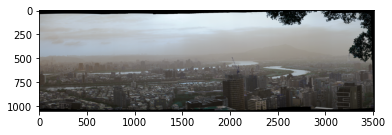

In [117]:
fns = sorted(glob.glob(os.path.join("input_img","*.jpg")))
print(fns)
img = []
kp, des = [], []
pre, cur = None, None

img = cv.imread(fns[0])
resize_ratio = 8
dim = ( img.shape[0] // resize_ratio, img.shape[1] // resize_ratio )
print("Resized dimension:", dim)

# assume we can get the focal length estimate
focal = []
with open(os.path.join("input_img", "pano.txt")) as f:
  ind = 1
  for line in f:
    if ind % 13 == 12:
      focal.append(float(line))
    ind += 1

# focal = [f/resize_ratio for f in focal]

print("focal lengths:", focal)

class Partial_img:
  def __init__(self, img = None, kp = None, des = None):
    self.img = img
    self.kp = kp
    self.des = des
panorama = None
for i in tqdm(range(len(fns))):
  img = cv.resize(cv.imread(fns[i]), (dim[1], dim[0]))
  # img = cv.imread(fns[i])
  img = cylindrical_warp(img, focal[i])
  k, d = SIFT(img)

  cur = Partial_img(img, k, d)
  print( fns[i], "keypoint num:", len(k))
  if i == 0:
    panorama = cur.img
    pre, cur = cur, None
    continue
  p_pre, p_cur = match_feat(pre.kp, pre.des, cur.kp, cur.des)
  A, pairs = ransac(p_pre, p_cur)

  panorama, cur_img = stitch_img(panorama, cur.img, A)
  cur.img = cur_img
  cur.kp, cur.des = SIFT(cur_img)

  cv.imwrite('panorama.jpg', panorama)

  pre, cur = cur, None

plt.imshow(panorama)
